# Module 7. Clustering
# Introduction to clustering
## Lecture objectives
1. Examine the purposes and potential uses of clustering
2. Introduce more exploratory data analysis techniques, such as pairplots
3. Demonstrate how to implement k-means clustering

## Why cluster?
Cluster analysis is an exploratory technique to identify sensible groupings in a dataset. The analyst has no prior knowledge of what these clusters are, and the data are not labeled with the "correct" cluster. Thus, cluster analysis is an *unsupervised* machine learning technique.

Some potential applications of clustering:
* Identify types of Marine Protected Area (e.g., [Bohorquez et al. 2019](https://www.sciencedirect.com/science/article/pii/S0308597X19304439))
* Identify types of street networks (e.g., [Barrington-Leigh and Millard-Ball 2020](https://www.pnas.org/content/117/4/1941))
* Identify types of neighborhood (e.g., [Kendig 2007](https://www.tandfonline.com/doi/abs/10.1080/01944367608977731))
* Identify types of transit agencies (e.g. [Ederer et al. 2019](https://journals.sagepub.com/doi/full/10.1177/0361198119852074))
* Identify patterns of cruising for parking (e.g. [Millard-Ball, Weinberger & Hampshire 2021](https://findingspress.org/article/28061-the-shape-of-cruising))

Clustering the data in this way can help you see regularities in the data that you can then interpret. It might suggest policies that are appropriate for one group of cities or agencies but not another. Or it could identify a peer group against which to benchmark (say) affordable housing construction costs or transit on-time performance.

## Types of clustering
Formally, clustering takes a set of *N* objects and finds *K* groups based on a measure of similarity. For a technical yet accessible overview, I recommend [Jain 2010](https://www.sciencedirect.com/science/article/abs/pii/S0167865509002323). 

The two broad groups of clustering algorithms are *hierarchical* and *partitional*. 

Ederer et al. (2019), for example, use a hierarchical algorithm to classify transit agencies.

<img src="https://journals.sagepub.com/na101/home/literatum/publisher/sage/journals/content/trra/2019/trra_2673_11/0361198119852074/20191218/images/medium/10.1177_0361198119852074-fig1.gif" style="width:50%;"/>


But let's start with a partitional algorithm. The most popular is called *k-means*. Again, this is an exploratory data analysis process. The analyst needs to specify the number of clusters *K*, and should experiment with different values of *K* until a meaningful grouping emerges. Another way to choose *K* is the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)), but we won't discuss that here.

## Example: precinct-level voting
We'll use the `sklearn` library to implement the k-means algorithm. The aim: identify a typology of voters based on precinct-level data.

The California [Statewide Database](https://statewidedatabase.org), maintained by UC Berkeley, provides access to voting data. Your GitHub repository should include the November 2020 precinct data for Los Angeles County.

In [1]:
import pandas as pd

df = pd.read_csv('../data/c037_g20_sov_data_by_g20_srprec.csv')
df.head()

,county,srprec,addist,cddist,sddist,bedist,TOTREG,DEMREG,REPREG,AIPREG,...,PR_23_Y,PR_24_N,PR_24_Y,PR_25_N,PR_25_Y,SENAIP01,SENDEM01,SENDEM02,SENLIB01,SENREP01
0,19,0050005A,36,25,21,1,1974,0,0,0,...,430,945,771,1304,398,0,524,0,0,1197
1,19,0050014A,36,25,21,1,697,0,0,0,...,100,314,223,427,116,0,163,0,0,373
2,19,0050022A,36,27,25,1,61,0,0,0,...,10,27,22,35,15,0,20,0,0,33
3,19,0050024A,41,27,25,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,19,0050025A,36,25,25,1,5,0,0,0,...,1,2,3,1,3,0,2,0,0,3


The unique identifier is given by the precinct column, `srprec`, so let's set that as the index.

In [2]:
df.set_index('srprec', inplace=True)
df.index.is_unique  # verify that it's unique

True

What columns are in the data set?

In [3]:
df.columns

Index(['county', 'addist', 'cddist', 'sddist', 'bedist', 'TOTREG', 'DEMREG',
       'REPREG', 'AIPREG', 'GRNREG', 'LIBREG', 'NLPREG', 'REFREG', 'DCLREG',
       'MSCREG', 'TOTVOTE', 'DEMVOTE', 'REPVOTE', 'AIPVOTE', 'GRNVOTE',
       'LIBVOTE', 'NLPVOTE', 'REFVOTE', 'DCLVOTE', 'MSCVOTE', 'PRCVOTE',
       'ABSVOTE', 'ASSDEM01', 'ASSDEM02', 'ASSGRN01', 'ASSIND01', 'ASSLIB01',
       'ASSREP01', 'ASSREP02', 'CNGDEM01', 'CNGDEM02', 'CNGREP01', 'PRSAIP01',
       'PRSDEM01', 'PRSGRN01', 'PRSLIB01', 'PRSPAF01', 'PRSREP01', 'PR_14_N',
       'PR_14_Y', 'PR_15_N', 'PR_15_Y', 'PR_16_N', 'PR_16_Y', 'PR_17_N',
       'PR_17_Y', 'PR_18_N', 'PR_18_Y', 'PR_19_N', 'PR_19_Y', 'PR_20_N',
       'PR_20_Y', 'PR_21_N', 'PR_21_Y', 'PR_22_N', 'PR_22_Y', 'PR_23_N',
       'PR_23_Y', 'PR_24_N', 'PR_24_Y', 'PR_25_N', 'PR_25_Y', 'SENAIP01',
       'SENDEM01', 'SENDEM02', 'SENLIB01', 'SENREP01'],
      dtype='object')

There are obviously a lot of columns. You can see the [full codebook here](https://statewidedatabase.org/d10/g20.html). But the propositions are pretty self explanatory. `PRSDEM01` gives votes for Biden, `PRSREP01` for Trump, etc. Note the state Senate and Assembly races will have different candidates depending on the precinct, so let's ignore those.

What do the data in these columns look like?

In [4]:
df[['PRSDEM01','PRSREP01']].head()

,PRSDEM01,PRSREP01
srprec,,
0050005A,595,1207
0050014A,185,376
0050022A,21,33
0050024A,1,0
0050025A,2,3


We see that the numbers are in absolute terms. Let's convert them to vote share.

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> How would you create a new column with percentage vote share for Biden and Trump?
</div>

In [5]:
# this is share of two-party vote (ignoring other candidates)
df['Biden_pc'] = df.PRSDEM01 / (df.PRSDEM01+df.PRSREP01)*100

Let's do the same for each proposition too. 

How can we get a list with the numbers of the propositions? We'll use a list comprehension to get the list of relevant columns.

In [6]:
props = [col for col in df.columns if col.startswith('PR_') and col.endswith('Y')]
print(props)

['PR_14_Y', 'PR_15_Y', 'PR_16_Y', 'PR_17_Y', 'PR_18_Y', 'PR_19_Y', 'PR_20_Y', 'PR_21_Y', 'PR_22_Y', 'PR_23_Y', 'PR_24_Y', 'PR_25_Y']


And another list comprehension to get the relevant proposition numbers. Note that these are always the 4th and 5th characters.

In [7]:
# we can use our string indexing to get the 4th and 5th characters
# for example
print('PR_14_Y'[3:5])

# apply this in a list comprehension
props = [prop[3:5] for prop in props]
print(props)

# we could have done this in one go
print([col[3:5] for col in df.columns if col.startswith('PR_') and col.endswith('Y')])

14
['14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25']
['14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25']


Now, let's loop over this list of propositions to calculate the vote share.

In [8]:
for prop in props:
    df[prop+'_pc_yes'] = df['PR_'+prop+'_Y'] / (df['PR_'+prop+'_Y'] 
                                              + df['PR_'+prop+'_N'])*100
df.head()

,county,addist,cddist,sddist,bedist,TOTREG,DEMREG,REPREG,AIPREG,GRNREG,...,16_pc_yes,17_pc_yes,18_pc_yes,19_pc_yes,20_pc_yes,21_pc_yes,22_pc_yes,23_pc_yes,24_pc_yes,25_pc_yes
srprec,,,,,,,,,,,,,,,,,,,,,
0050005A,19,36,25,21,1,1974,0,0,0,0,...,20.081019,33.865450,22.165242,36.484919,50.058275,22.344748,69.155093,25.087515,44.930070,23.384254
0050014A,19,36,25,21,1,697,0,0,0,0,...,18.081181,32.783883,20.292505,35.140187,51.201479,19.038817,70.985401,18.518519,41.527002,21.362799
0050022A,19,36,27,25,1,61,0,0,0,0,...,27.272727,41.509434,25.925926,43.396226,42.307692,22.641509,75.000000,18.867925,44.897959,30.000000
0050024A,19,41,27,25,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0050025A,19,36,25,25,1,5,0,0,0,0,...,40.000000,40.000000,20.000000,75.000000,20.000000,0.000000,60.000000,20.000000,60.000000,75.000000


### Inspect and standardize the data

Number 1 rule: before applying any algorithm to your data, look at it!

We could create a scatterplot matrix manually. But `seaborn` has a [nice function to do this for us](https://seaborn.pydata.org/examples/scatterplot_matrix.html).

In [9]:
import seaborn as sns

sns.pairplot?

Signature:
sns.pairplot(
    data,
    *,
    hue=None,
    hue_order=None,
    palette=None,
    vars=None,
    x_vars=None,
    y_vars=None,
    kind='scatter',
    diag_kind='auto',
    markers=None,
    height=2.5,
    aspect=1,
    corner=False,
    dropna=False,
    plot_kws=None,
    diag_kws=None,
    grid_kws=None,
    size=None,
)
Docstring:
Plot pairwise relationships in a dataset.

By default, this function will create a grid of Axes such that each numeric
variable in ``data`` will by shared across the y-axes across a single row and
the x-axes across a single column. The diagonal plots are treated
differently: a univariate distribution plot is drawn to show the marginal
distribution of the data in each column.

It is also possible to show a subset of variables or plot different
variables on the rows and columns.

This is a high-level interface for :class:`PairGrid` that is intended to
make it easy to draw a few common styles. You should use :class:`PairGrid`
directly if you

We'll plot a subset of the columns, ignoring a few of the less critical propositions. Should stem cell research and dialysis rules really be on the ballot?

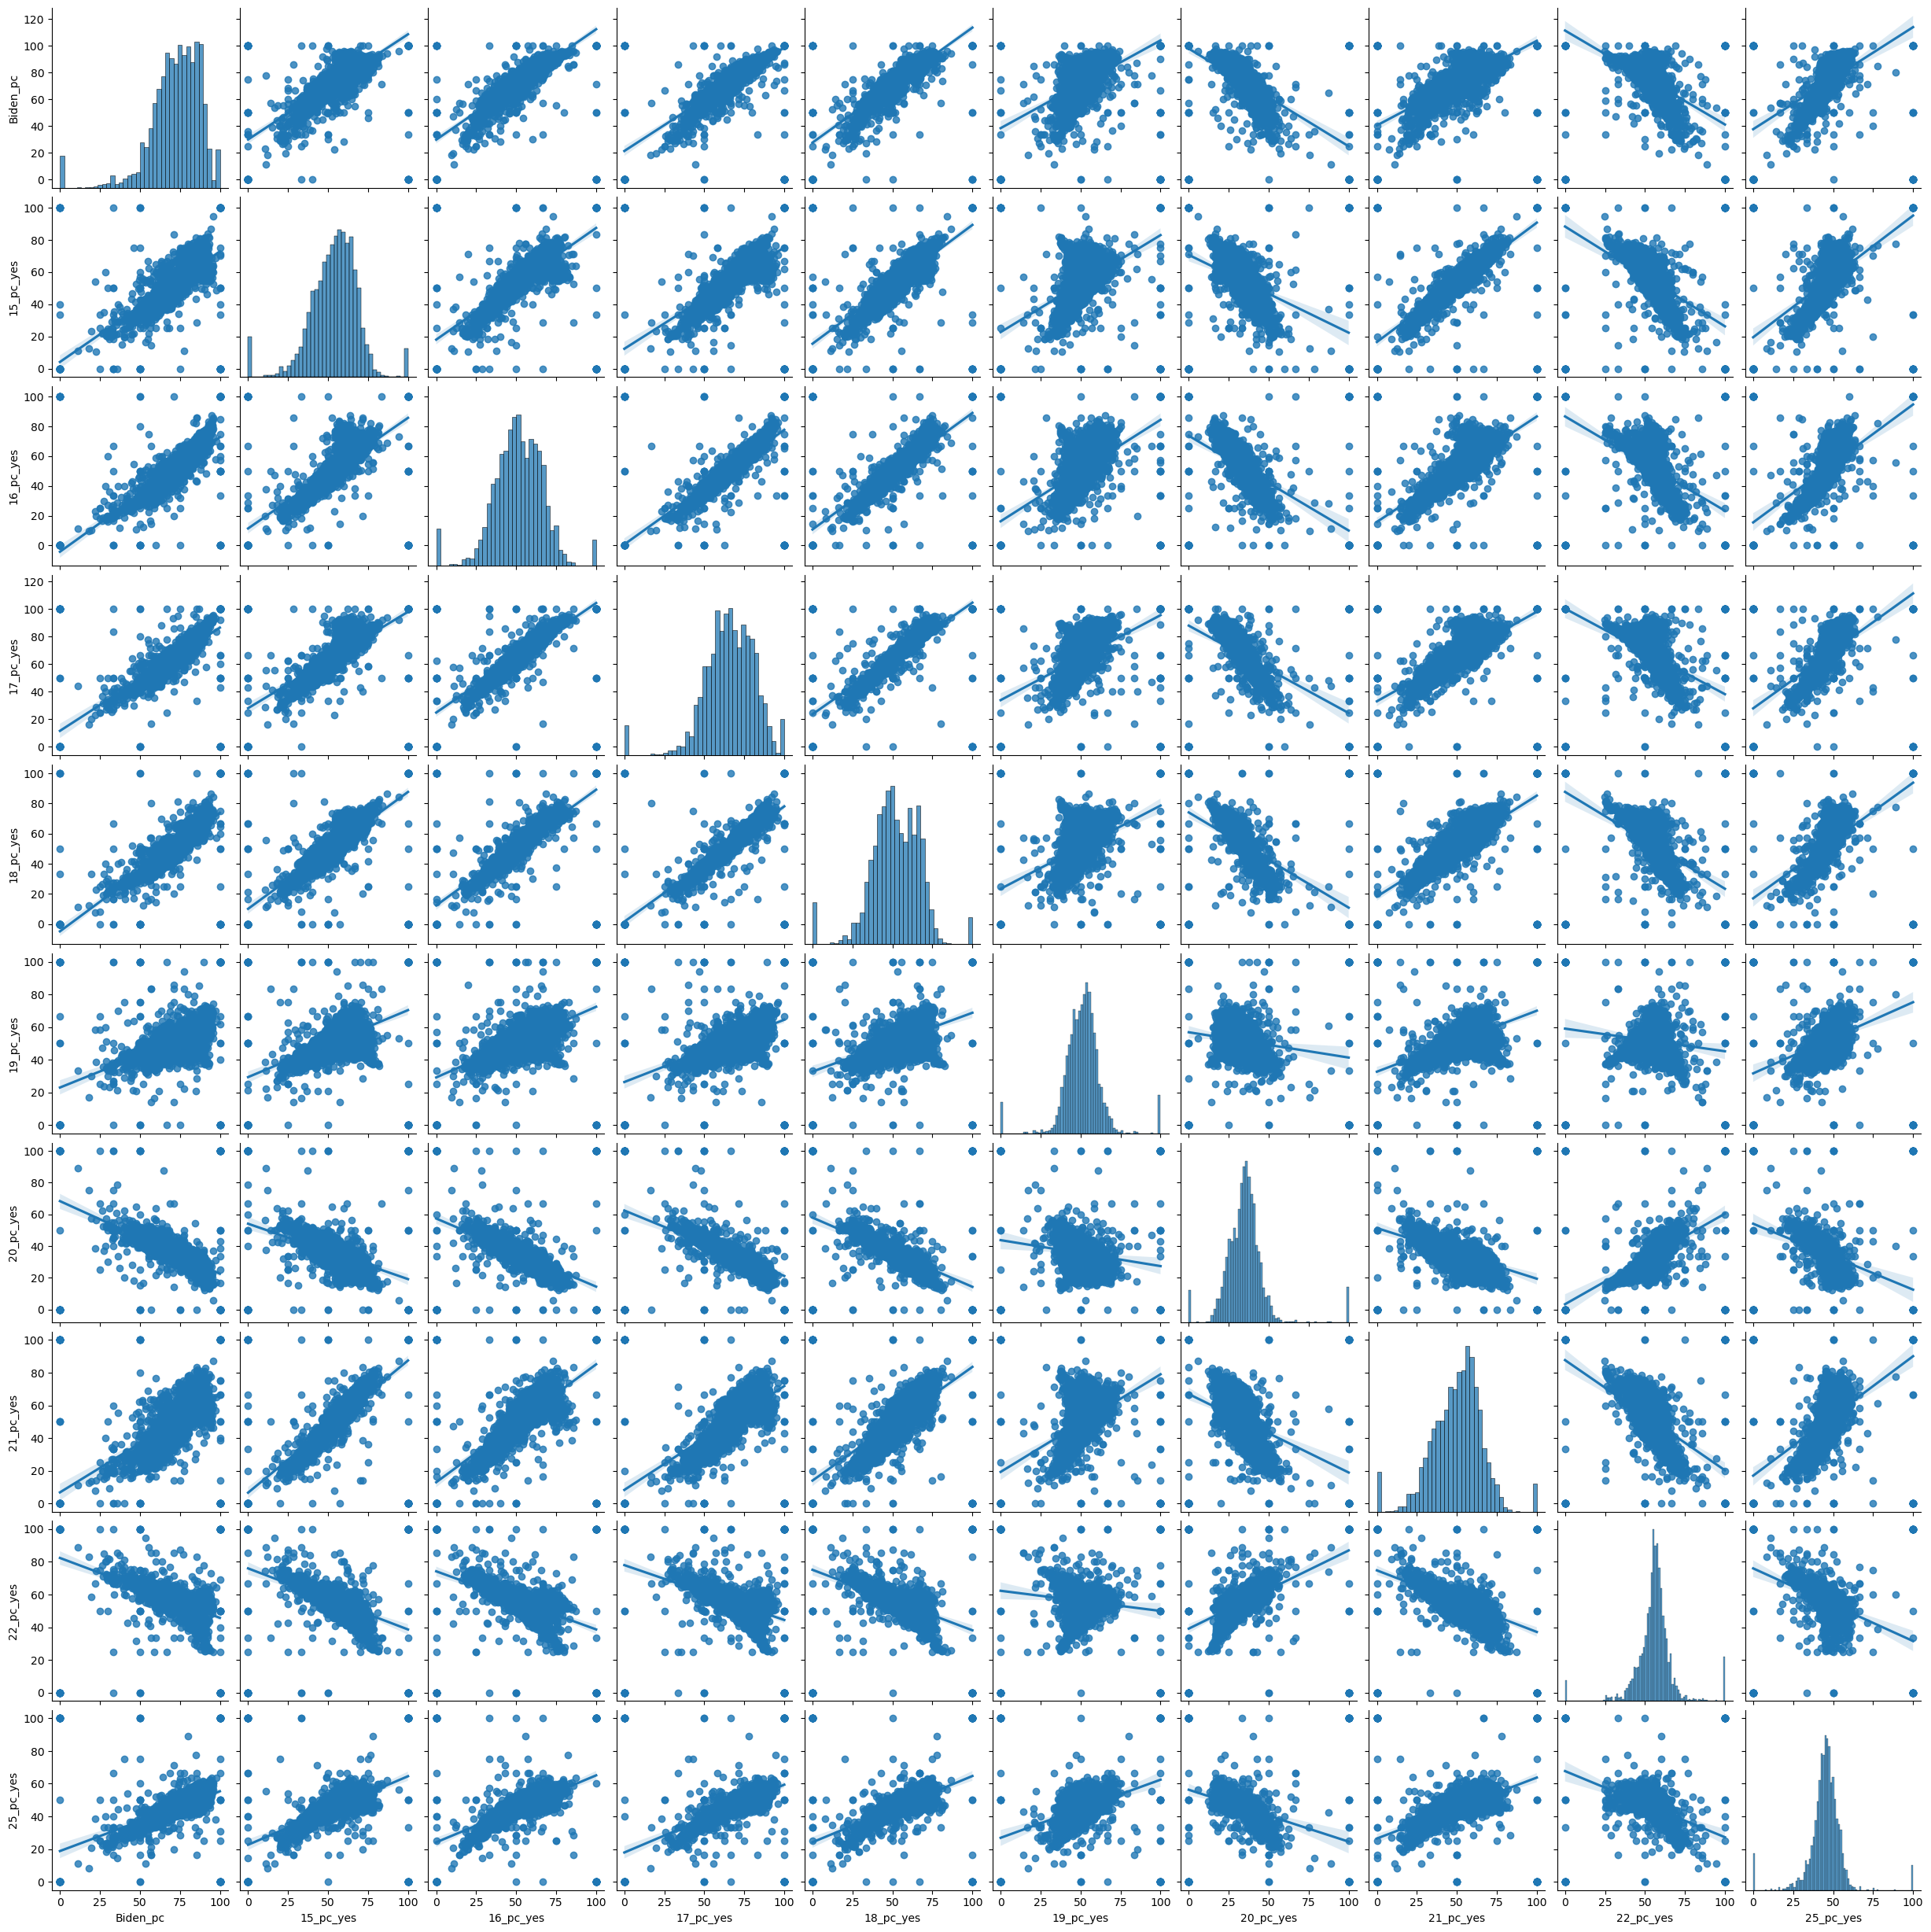

In [10]:
# get a list of all the columns with 'pc' in the name
cols_to_plot = [col for col in df.columns if '_pc' in col]

# remove those we don't want
cols_to_plot.remove('14_pc_yes') 
cols_to_plot.remove('23_pc_yes') 
cols_to_plot.remove('24_pc_yes') 

# kind='reg' adds the line of best fit
ax = sns.pairplot(df[cols_to_plot], kind='reg')  

There are pretty strong relationships between Presidential voting and the propositions. All have a positive correlation except for Prop 20 (harsher sentencing) and Prop 22 (independent contractor status for drivers for Uber, Doordash, etc.). [A helpful reminder of the propositions is here](https://ballotpedia.org/California_2020_ballot_propositions).

But there isn't a perfect relationship. Perhaps cluster analysis can reveal some groupings? In other words, do precincts cluster according to ideological "types"?

First, it helps to pre-process the data in two ways:
* Let's align the data so that a higher percent means more progressive. This means using the percent "no" for Props 20 and 22
* We should standardize each variable to mean zero and standard deviation one. This helps ensure that the distances in multidimensional space are consistent. (Since we have a percentage measure, it won't make much difference compared to a variable like population, but it's good practice.)

In [ ]:
cols_to_plot

In [11]:
for prop in ['20','22']:
    df[prop+'_pc_no'] = 100 - df[prop+'_pc_yes']
    df.drop(columns=[prop+'_pc_yes'], inplace=True)

# then rerun the same code as above
cols_to_plot = [col for col in df.columns if '_pc' in col]
cols_to_plot.remove('14_pc_yes') 
cols_to_plot.remove('23_pc_yes') 
cols_to_plot.remove('24_pc_yes') 

# see https://scikit-learn.org/stable/modules/preprocessing.html for standardization
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(df[cols_to_plot])

# as in the previous lecture, 
# the scaler returns a numpy array, so we cast this as a DataFrame 
# and need to specify the column names and index
df_scaled = pd.DataFrame(scaler.transform(df[cols_to_plot]), 
                         columns=cols_to_plot, index=df.index)

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Unpack each step in the previous lines of code, and find out what is returned by <strong>scaler</strong> and <strong>scaler.transform(df[cols_to_plot])</strong>.
</div>

Let's check that our data still look reasonable by rerunning the same pairplot.

Notice that the y axes run from about -3 to +3. This should be true for any standardized variable, as most observations are within 3 standard deviations of the mean.

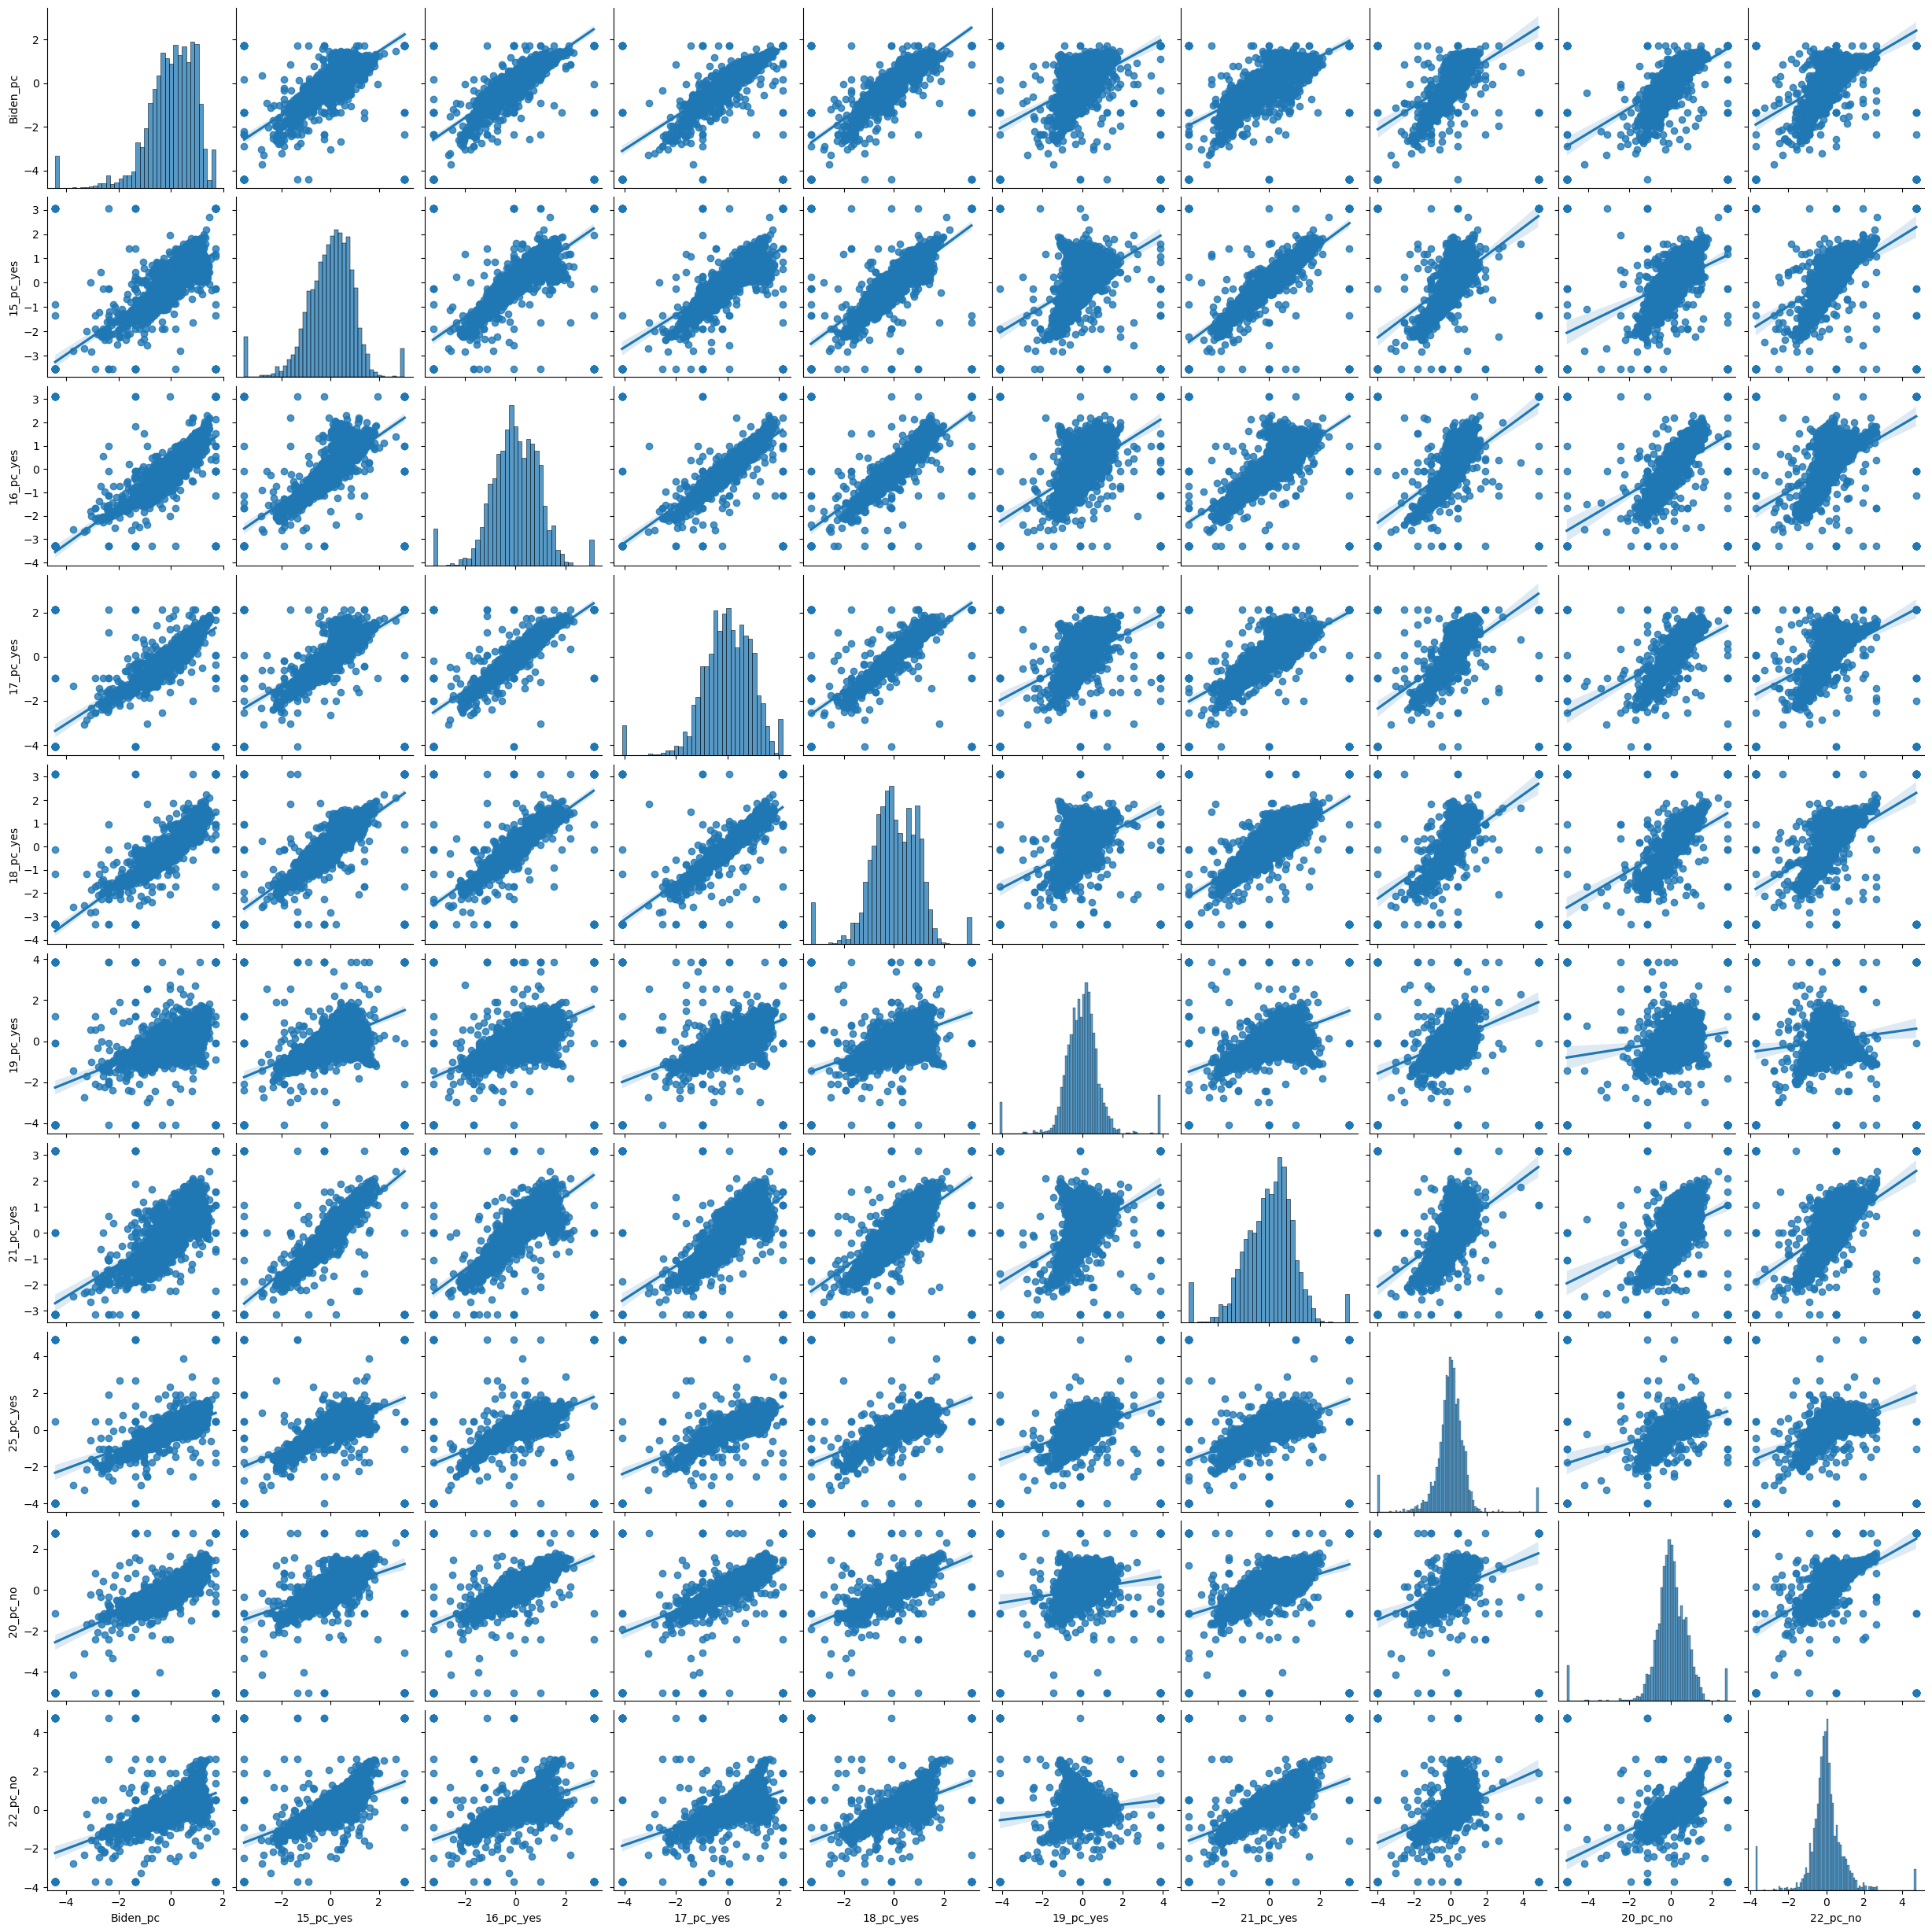

In [14]:
ax = sns.pairplot(df_scaled, kind='reg')

### KMeans in scikit-learn
As always, the data wrangling was a large part of our work. Now, we are ready to do the cluster analysis, which is much simpler.

The documention has some useful examples.

In [15]:
from sklearn.cluster import KMeans
# KMeans?

We can specify the number of clusters. Optionally, we can specify the random state, so that we can reproduce our work. 

Then we fit to our data, in this case `df_scaled`.

In [16]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(df_scaled)

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Here, the error message is pretty helpful. Let's drop the NaNs.

In [17]:
print(len(df_scaled))
df_scaled = df_scaled.dropna()
print(len(df_scaled))

kmeans = KMeans(n_clusters=5, random_state=1).fit(df_scaled)
print(kmeans)

4313
3082
KMeans(n_clusters=5, random_state=1)


/Users/chaithra/opt/anaconda3/envs/uds/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


It's not immediately obvious what we can do with this `KMeans` object. But let's explore it. Use the tab autocomplete to see the different methods.

In [ ]:
kmeans.

The cluster centers are defined by the (standardized) value for each variable. Each observation is assigned to the cluster with the closest center.

In [18]:
kmeans.cluster_centers_

array([[-0.39868164, -0.47403582, -0.49073988, -0.4668846 , -0.48045893,
        -0.27889852, -0.4804702 , -0.25393817, -0.29063614, -0.25345148],
       [ 0.88898809,  0.89187034,  1.02595437,  0.98593938,  1.04247503,
         0.44285323,  0.8462755 ,  0.662479  ,  0.71700918,  0.62849294],
       [-1.33807399, -1.29276015, -1.30568913, -1.28348588, -1.31389353,
        -0.87488858, -1.30468159, -0.94786846, -0.81041798, -0.79605981],
       [-4.14735076, -3.27988948, -3.12701801, -3.061108  , -3.06569169,
        -2.7174734 , -2.6678734 , -3.44913461, -3.21084094, -3.61112607],
       [ 0.27492897,  0.28780969,  0.18762191,  0.18221679,  0.1389614 ,
         0.32370366,  0.31921301,  0.16485511,  0.08693887,  0.11717051]])

Notice that the `cluster_centers_` is an array that is `K x L`, where `K` is the number of clusters and `L` is the number of variables.

Here, we have 5 clusters, and we used 10 variables to define the clusters.

In [20]:
print(kmeans.cluster_centers_.shape)
print(len(df_scaled.columns))

(5, 10)
10


The `labels_` attribute gives the label of the cluster to which each observation (i.e., each precinct) is assigned.

In [21]:
kmeans.labels_

array([2, 2, 2, ..., 0, 3, 4], dtype=int32)

So there are as many labels as rows in our dataframe.

In [22]:
print(kmeans.labels_.shape)
print(len(df_scaled))

(3082,)
3082


That means that we can simply add the cluster id back to our original dataframe!

In [23]:
df_scaled['cluster_id'] = kmeans.labels_

/var/folders/cx/5hr478816plb9gd8v3v207d40000gn/T/ipykernel_90018/1301201035.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scaled['cluster_id'] = kmeans.labels_


How large is each cluster? Note that the algorithm doesn't aim to produce equal-size groupings.

In [24]:
df_scaled.groupby('cluster_id').size()

cluster_id
0    858
1    888
2    412
3     32
4    892
dtype: int64

<div class="alert alert-block alert-info">
<h3>Key Takeaways</h3>
<ul>
  <li>Cluster analysis is an exploratory data tool</li>
  <li>They are an example of <em>data reduction</em>—reducing your data to something that can be readily interpreted</li>
</div>